In [216]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
!pip install rasterio scikit-learn -q

In [238]:
source_folder = '/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/'

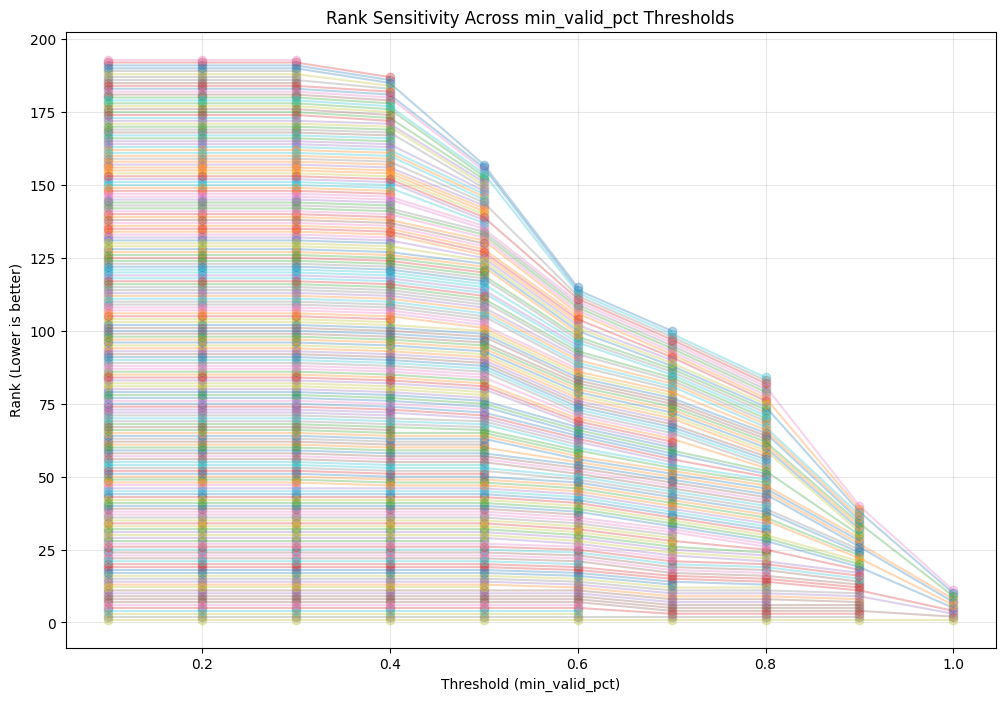

In [218]:
import pandas as pd
import numpy as np
from scipy.stats import gmean
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Define thresholds for sensitivity analysis
thresholds = np.arange(0.1, 1.05, 0.1)  # 0.4 to 1.0 in steps of 0.1

# Load preprocessed data
df_P1 = pd.read_csv(os.path.join(source_folder, 'Merged_Exposure_Data.csv'))
df_P2_full = pd.read_csv(os.path.join(source_folder, 'P2_Merged_Normalized_avg.csv'))

results = []  # To store ranks and scores for each threshold

# Precompute P1 normalized scores
hazard_groups = {
    'river_flood': ['river_flood'],
    'coastal_flood': ['coastal_flood'],
    'storm': ['tropical_storm'],
    'drought': ['agricultural_drought', 'drought_spei', 'drought_spi'],
    'heatwave': ['heatwave_frequency', 'heatwave_duration', 'heatwave_severity'],
    'extreme_heat': ['extreme_heat'],
    'fire': ['fire_FRP', 'fire_frequency'],
    'sand_dust': ['sand_dust'],
    'air_pollution': ['air_pollution'],
    'malaria': ['vectorborne_malariapv', 'vectorborne_malariapf']
}

group_mean_columns = []
for group, hazards in hazard_groups.items():
    group_means = []
    for hazard in hazards:
        abs_col = f"{hazard}_absolute"
        rel_col = f"{hazard}_relative"
        mean_col = f"{hazard}_mean"
        df_P1[mean_col] = df_P1[[abs_col, rel_col]].apply(
            lambda row: gmean(row.replace(0, np.nan).dropna()) if len(row.replace(0, np.nan).dropna()) > 0 else np.nan,
            axis=1
        )
        group_means.append(mean_col)

    group_col = f"{group}_gmean"
    df_P1[group_col] = df_P1[group_means].apply(
        lambda row: gmean(row.replace(0, np.nan).dropna()) if len(row.replace(0, np.nan).dropna()) > 0 else np.nan,
        axis=1
    )
    group_mean_columns.append(group_col)

df_P1['P1_geometric_avg'] = df_P1[group_mean_columns].apply(
    lambda row: gmean(row.replace(0, np.nan).dropna()) if len(row.replace(0, np.nan).dropna()) > 0 else np.nan,
    axis=1
)

scaler = MinMaxScaler(feature_range=(0, 10))
df_P1['P1_geometric_avg'] = scaler.fit_transform(df_P1[['P1_geometric_avg']]).flatten()
df_P1_grouped = df_P1.groupby('iso3', as_index=False)['P1_geometric_avg'].mean()

pillar2_columns = [col for col in df_P2_full.columns if col.endswith('_value_normalized')]

# Perform sensitivity analysis
for threshold in thresholds:
    df_P2 = df_P2_full.copy()

    # Apply threshold filter
    df_P2 = df_P2[df_P2[pillar2_columns].notna().sum(axis=1) / len(pillar2_columns) >= threshold]

    # Compute domain averages
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        health_prefixes = ['P2_DTP1_access', 'P2_DTP3_access', 'P2_Skilled_birth_coverage', 'P2_electricity_access']
        nutrition_prefixes = ['P2_Stunting', 'P2_Child_Food_Poverty']
        wash_prefixes = ['P2_At-least_basic_drinking_water', 'P2_At-least_basic_sanitation', 'P2_Basic_hygiene']
        education_prefixes = ['P2_Lower_secondary_out_of_school', 'P2_Lower_secondary_completion_rate', 'P2_Learning_poverty']
        protection_prefixes = ['P2_Child_labor', 'P2_Child_marriage']
        poverty_prefixes = ['P2_Child_poverty', 'P2_Under_five_covered_by_social_protection']
        survival_prefixes = ['P2_Under_five_mortality']

        domains = {
            'health': [c for c in df_P2.columns if any(c.startswith(p) for p in health_prefixes)],
            'nutrition': [c for c in df_P2.columns if any(c.startswith(p) for p in nutrition_prefixes)],
            'wash': [c for c in df_P2.columns if any(c.startswith(p) for p in wash_prefixes)],
            'education': [c for c in df_P2.columns if any(c.startswith(p) for p in education_prefixes)],
            'protection': [c for c in df_P2.columns if any(c.startswith(p) for p in protection_prefixes)],
            'poverty': [c for c in df_P2.columns if any(c.startswith(p) for p in poverty_prefixes)],
            'survival': [c for c in df_P2.columns if any(c.startswith(p) for p in survival_prefixes)]
        }

        domain_means = {k: df_P2[v].apply(np.nanmean, axis=1) for k, v in domains.items()}
        domains_df = pd.DataFrame(domain_means)

    df_P2['P2_arithmetic_avg'] = domains_df.apply(np.nanmean, axis=1)

    # Merge with P1
    merged = df_P1_grouped.merge(df_P2[['iso3', 'P2_arithmetic_avg']], on='iso3', how='inner')

    # Compute combined geometric mean
    merged['P1_P2_geometric_avg'] = merged.apply(
        lambda row: gmean([row['P1_geometric_avg'] + 1e-10, row['P2_arithmetic_avg'] + 1e-10])
        if not np.isnan(row['P1_geometric_avg']) and not np.isnan(row['P2_arithmetic_avg']) else np.nan,
        axis=1
    )

    # Rank countries
    merged['rank'] = merged['P1_P2_geometric_avg'].rank(method='average', ascending=False)

    # Save results
    for _, row in merged.iterrows():
        results.append({
            'iso3': row['iso3'],
            'threshold': threshold,
            'score': row['P1_P2_geometric_avg'],
            'rank': row['rank']
        })

# Convert results to DataFrame
sensitivity_df = pd.DataFrame(results)

# Save to file
sensitivity_df.to_csv(os.path.join(destination_folder, 'sensitivity_analysis_P1P2.csv'), index=False)

# Visualization: rank change
pivot_rank = sensitivity_df.pivot(index='iso3', columns='threshold', values='rank')

plt.figure(figsize=(12, 8))
for iso3 in pivot_rank.index:
    plt.plot(pivot_rank.columns, pivot_rank.loc[iso3], marker='o', alpha=0.3)
plt.xlabel('Threshold (min_valid_pct)')
plt.ylabel('Rank (Lower is better)')
plt.title('Rank Sensitivity Across min_valid_pct Thresholds')
plt.grid(alpha=0.3)
plt.show()


In [230]:
# Round the threshold column to 2 decimals
sensitivity_df['threshold'] = sensitivity_df['threshold'].round(2)

# Now select countries at threshold 0.9
countries_at_09 = sensitivity_df.loc[sensitivity_df['threshold'] == 0.9, 'iso3'].unique()
print(f"Number of countries at threshold 0.9: {len(countries_at_09)}")
print(countries_at_09)



Number of countries at threshold 0.9: 40
['AGO' 'ARM' 'BDI' 'BEN' 'BGD' 'CIV' 'CMR' 'COD' 'COL' 'CRI' 'DOM' 'ETH'
 'GIN' 'HND' 'IND' 'IRQ' 'KGZ' 'KIR' 'LAO' 'LKA' 'LSO' 'MDG' 'MEX' 'MLI'
 'MMR' 'MRT' 'MWI' 'NGA' 'PAK' 'PRY' 'SEN' 'SLE' 'SUR' 'TCD' 'TGO' 'TKM'
 'TLS' 'ZAF' 'ZMB' 'ZWE']


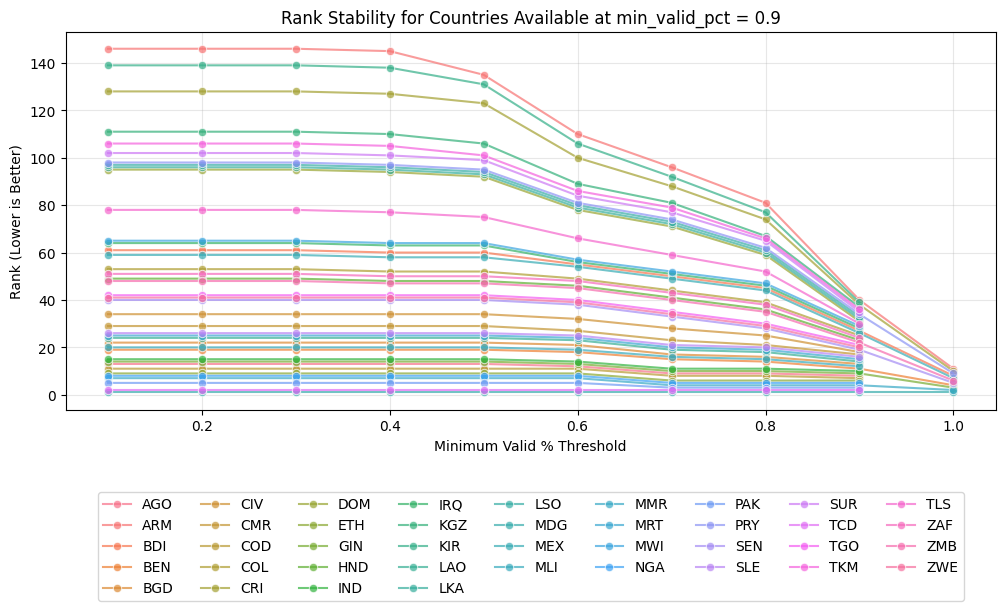

In [220]:
# Filter sensitivity_df for these countries only
stable_countries_df = sensitivity_df[sensitivity_df['iso3'].isin(countries_at_09)]

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=stable_countries_df,
    x='threshold',
    y='rank',
    hue='iso3',  # this automatically creates a legend
    marker='o',
    alpha=0.7
)

plt.title('Rank Stability for Countries Available at min_valid_pct = 0.9')
plt.xlabel('Minimum Valid % Threshold')
plt.ylabel('Rank (Lower is Better)')
plt.gca() # Invert y-axis to put Rank 1 at the top
plt.grid(alpha=0.3)

# Relocate the legend to the bottom
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=9)
plt.subplots_adjust(bottom=0.25)

plt.show()

/tmp/ipython-input-2613064293.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rank_summary = plot_df.groupby('iso3').apply(


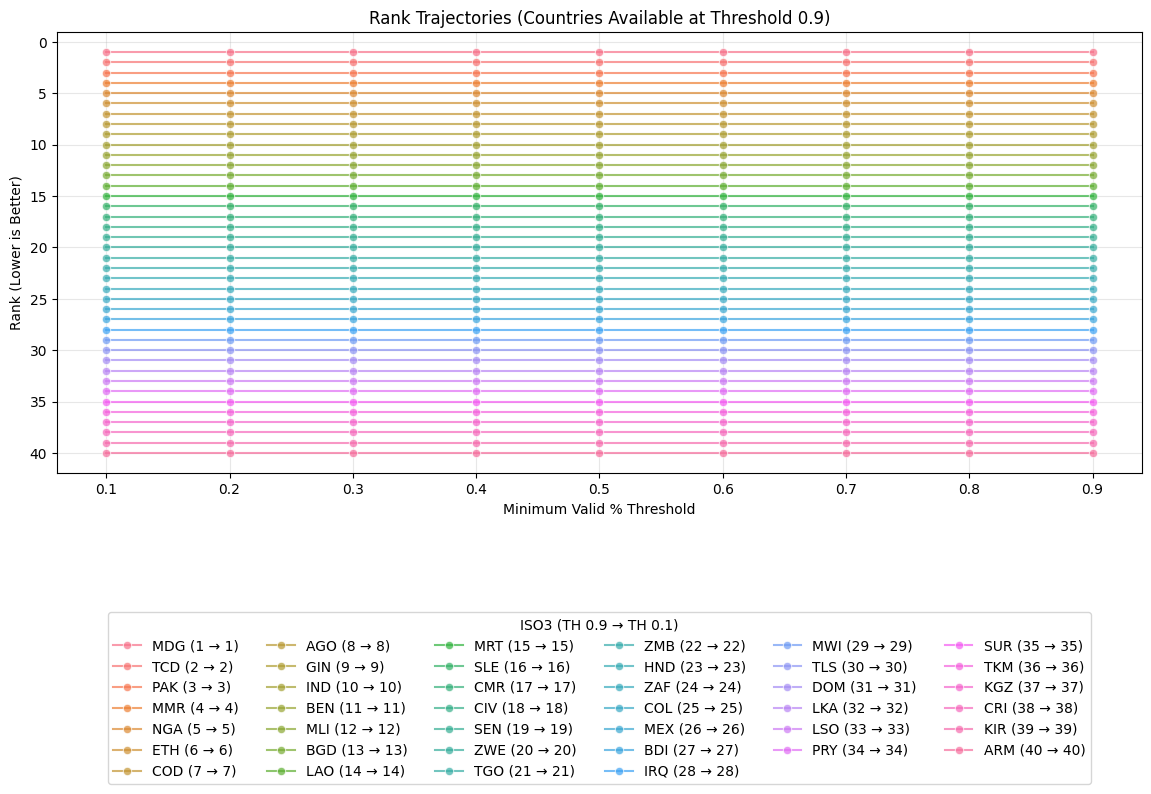

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

# Round threshold to avoid floating point issues
sensitivity_df['threshold'] = sensitivity_df['threshold'].round(2)

# Countries available at 0.9
countries_at_09 = sensitivity_df.loc[sensitivity_df['threshold'] == 0.9, 'iso3'].unique()

# Filter only these countries and thresholds <= 0.9
plot_df = sensitivity_df[
    (sensitivity_df['iso3'].isin(countries_at_09)) &
    (sensitivity_df['threshold'] <= 0.9)
].copy()

# Recompute ranks within this subset for each threshold
plot_df['rank_subset'] = plot_df.groupby('threshold')['score'] \
    .rank(method='average', ascending=False)

# Compute rank change for legend
rank_summary = plot_df.groupby('iso3').apply(
    lambda df: f"{int(df.loc[df['threshold'] == 0.9, 'rank_subset'].values[0])} → "
    f"{int(df.loc[df['threshold'] == df['threshold'].min(), 'rank_subset'].values[0])}"
).to_dict()

# Create label: ISO3 + rank change
plot_df['label'] = plot_df['iso3'] + " (" + plot_df['iso3'].map(rank_summary) + ")"

# Sort labels by rank at threshold 0.9
initial_ranks = plot_df[plot_df['threshold'] == 0.9][['label', 'rank_subset']].sort_values('rank_subset')
hue_order = initial_ranks['label'].tolist()

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=plot_df,
    x='threshold',
    y='rank_subset',
    hue='label',
    hue_order=hue_order,  # ensure legend is sorted
    marker='o',
    alpha=0.7
)

plt.title('Rank Trajectories (Countries Available at Threshold 0.9)')
plt.xlabel('Minimum Valid % Threshold')
plt.ylabel('Rank (Lower is Better)')
plt.gca()
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)

# Relocate the legend to the bottom
plt.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc='upper center',
    title='ISO3 (TH 0.9 → TH 0.1)',
    ncol=6
)
plt.subplots_adjust(bottom=0.25)

plt.show()

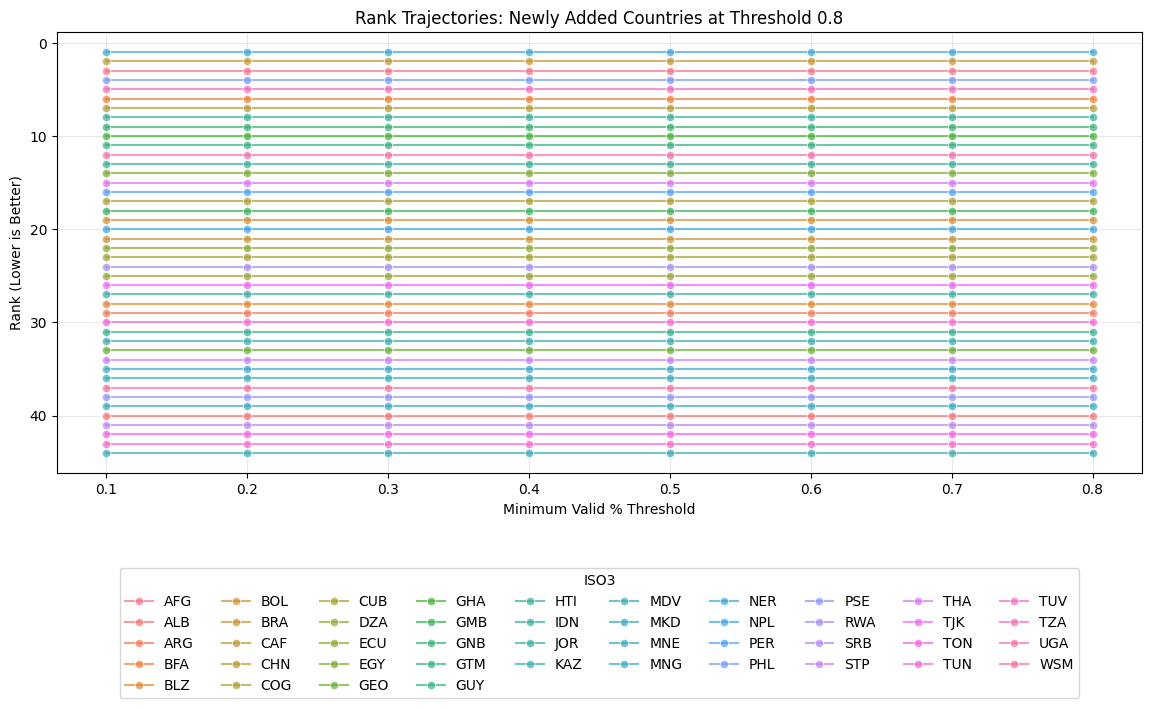

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Round threshold to avoid floating point issues
sensitivity_df['threshold'] = sensitivity_df['threshold'].round(2)

# Step 1: Identify countries fully available at 0.9
countries_at_09 = sensitivity_df[sensitivity_df['threshold'] == 0.9]['iso3'].unique()

# Step 2: Identify countries newly added at 0.8
countries_at_08 = sensitivity_df[sensitivity_df['threshold'] == 0.8]['iso3'].unique()
new_countries_08 = np.setdiff1d(countries_at_08, countries_at_09)

# Step 3: Prepare data for plotting
plot_df = sensitivity_df[sensitivity_df['iso3'].isin(new_countries_08)].copy()

# Step 4: Compute ranks per threshold (descending = better)
plot_df['rank'] = plot_df.groupby('threshold')['score'].rank(method='average', ascending=False)

# Step 5: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=plot_df,
    x='threshold',
    y='rank',
    hue='iso3',
    marker='o',
    alpha=0.7
)

plt.title('Rank Trajectories: Newly Added Countries at Threshold 0.8')
plt.xlabel('Minimum Valid % Threshold')
plt.ylabel('Rank (Lower is Better)')
plt.gca().invert_yaxis()  # Rank 1 at top
plt.grid(alpha=0.3)

# Relocate the legend to the bottom
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', title='ISO3', ncol=10)
plt.subplots_adjust(bottom=0.25)

plt.show()

In [223]:
thresholds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

{'PRY', 'MEX', 'BEN', 'ZMB', 'SEN', 'CRI', 'ARM', 'BDI', 'MMR', 'MDG', 'GIN'}
{'TKM', 'TCD', 'BEN', 'ZMB', 'NGA', 'BDI', 'MMR', 'LSO', 'PRY', 'LAO', 'MEX', 'SEN', 'IRQ', 'BGD', 'PAK', 'HND', 'MWI', 'ETH', 'MLI', 'TLS', 'DOM', 'CRI', 'LKA', 'KGZ', 'COL', 'GIN', 'TGO', 'CIV', 'ZAF', 'MRT', 'CMR', 'ZWE', 'IND', 'SLE', 'COD', 'ARM', 'MDG', 'SUR', 'KIR', 'AGO'}
{'NGA', 'GHA', 'BRA', 'ETH', 'LKA', 'COL', 'CIV', 'ZAF', 'THA', 'SLE', 'COD', 'IDN', 'MNE', 'AGO', 'ZMB', 'JOR', 'GTM', 'STP', 'GMB', 'ALB', 'LAO', 'PRY', 'MEX', 'CAF', 'BOL', 'MDV', 'CUB', 'KAZ', 'CHN', 'BGD', 'WSM', 'HND', 'DOM', 'TLS', 'ARG', 'RWA', 'UGA', 'DZA', 'KIR', 'TON', 'TKM', 'MNG', 'TCD', 'NPL', 'HTI', 'AFG', 'TJK', 'IRQ', 'TZA', 'PAK', 'KGZ', 'MRT', 'CMR', 'TUN', 'ZWE', 'MKD', 'ARM', 'ECU', 'EGY', 'BEN', 'BLZ', 'PSE', 'BDI', 'MMR', 'NER', 'PHL', 'LSO', 'BFA', 'SEN', 'COG', 'MWI', 'MLI', 'PER', 'SRB', 'CRI', 'TUV', 'GIN', 'TGO', 'GEO', 'IND', 'GNB', 'GUY', 'MDG', 'SUR'}
{'KHM', 'NGA', 'PNG', 'TUR', 'GHA', 'BRA', 'ETH', 'L

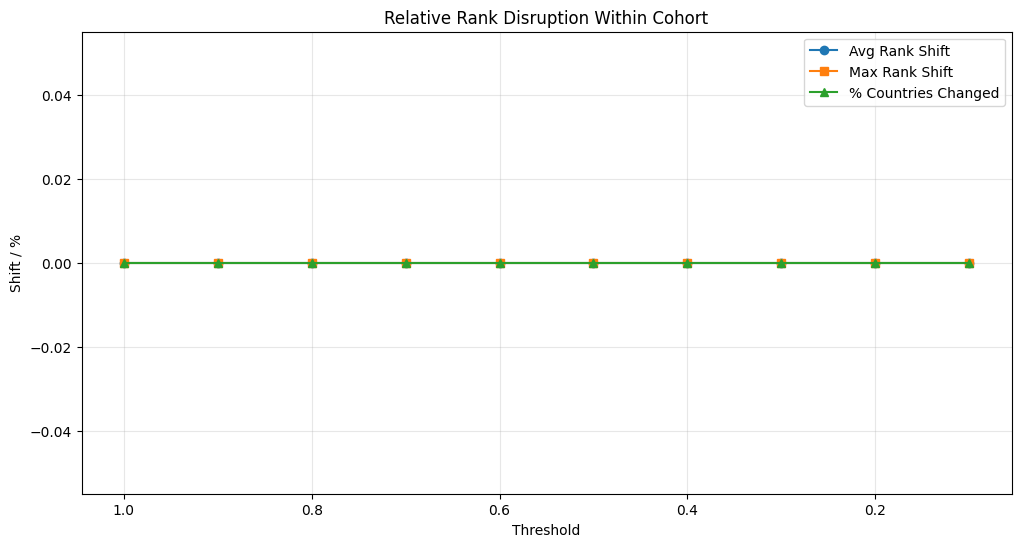

In [224]:
import pandas as pd
import matplotlib.pyplot as plt

# Round thresholds
sensitivity_df['threshold'] = sensitivity_df['threshold'].round(2)

# Sort thresholds descending
thresholds = sorted(sensitivity_df['threshold'].unique(), reverse=True)

# Disruption metrics storage
disruption_summary = []

prev_countries = set()
prev_df = None

for t in thresholds:
    df_current = sensitivity_df[sensitivity_df['threshold'] == t].copy()
    df_current = df_current.sort_values(by='score', ascending=False)

    current_countries = set(df_current['iso3'])

    if prev_df is not None:
        # Intersection of countries present in both thresholds
        common = current_countries & prev_countries
        print(common)
        # Compute ranks within the intersection for both thresholds
        prev_ranks = prev_df[prev_df['iso3'].isin(common)].sort_values('score', ascending=False)
        prev_ranks['subset_rank'] = range(1, len(prev_ranks) + 1)

        curr_ranks = df_current[df_current['iso3'].isin(common)].sort_values('score', ascending=False)
        curr_ranks['subset_rank'] = range(1, len(curr_ranks) + 1)

        merged = pd.merge(prev_ranks[['iso3', 'subset_rank']], curr_ranks[['iso3', 'subset_rank']],
                          on='iso3', suffixes=('_prev', '_curr'))

        rank_shift = (merged['subset_rank_prev'] - merged['subset_rank_curr']).abs()
        avg_shift = rank_shift.mean()
        max_shift = rank_shift.max()
        pct_changed = (rank_shift > 0).mean() * 100
    else:
        avg_shift = 0
        max_shift = 0
        pct_changed = 0

    disruption_summary.append({
        'threshold': t,
        'avg_rank_shift': avg_shift,
        'max_rank_shift': max_shift,
        'pct_changed': pct_changed
    })

    # Update
    prev_countries = current_countries
    prev_df = df_current

# Convert to DataFrame
disruption_df = pd.DataFrame(disruption_summary)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(disruption_df['threshold'], disruption_df['avg_rank_shift'], marker='o', label='Avg Rank Shift')
plt.plot(disruption_df['threshold'], disruption_df['max_rank_shift'], marker='s', label='Max Rank Shift')
plt.plot(disruption_df['threshold'], disruption_df['pct_changed'], marker='^', label='% Countries Changed')
plt.gca().invert_xaxis()  # So we see 0.9 → 0.4 in left-to-right
plt.title('Relative Rank Disruption Within Cohort')
plt.xlabel('Threshold')
plt.ylabel('Shift / %')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


   threshold  n_common  kendall_tau  spearman_rho  mean_abs_rank_shift_common  \
0        1.0        11          1.0           1.0                         0.0   
1        0.9        40          1.0           1.0                         0.0   
2        0.8        40          1.0           1.0                         0.0   
3        0.7        40          1.0           1.0                         0.0   
4        0.6        40          1.0           1.0                         0.0   
5        0.5        40          1.0           1.0                         0.0   
6        0.4        40          1.0           1.0                         0.0   
7        0.3        40          1.0           1.0                         0.0   
8        0.2        40          1.0           1.0                         0.0   
9        0.1        40          1.0           1.0                         0.0   

   max_abs_rank_shift_common  inversion_rate  
0                        0.0             0.0  
1             

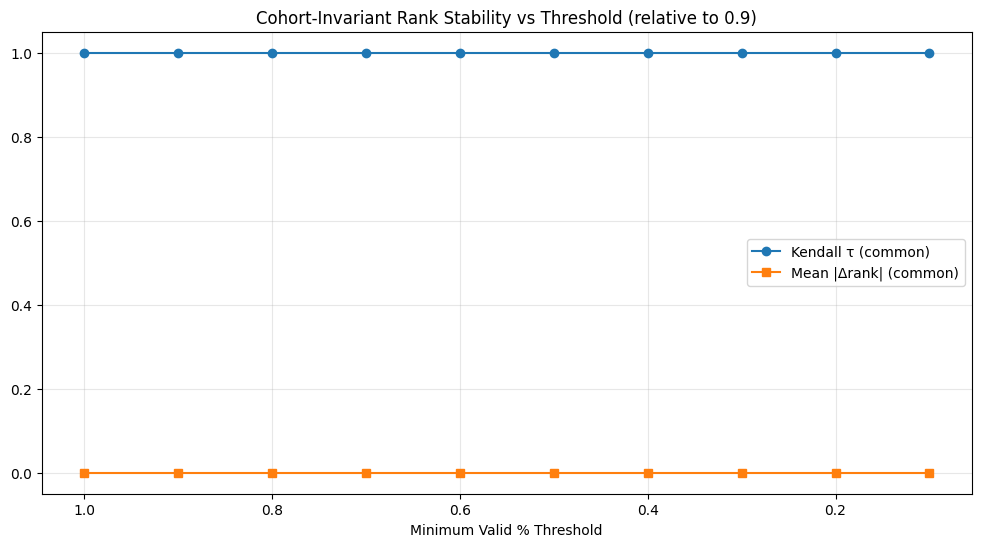

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr

# --- Prep ---
sensitivity_df['threshold'] = sensitivity_df['threshold'].round(2)
baseline_threshold = 0.9

# Baseline set & scores
base_df = sensitivity_df[sensitivity_df['threshold'] == baseline_threshold][['iso3','score']].dropna().copy()
base_iso = set(base_df['iso3'])

# Function to compute ranks within a given set of iso3 (cohort)
def ranks_within_common(df_scores, common_iso):
    sub = df_scores[df_scores['iso3'].isin(common_iso)].copy()
    # Rank higher scores as better (rank 1 = best)
    sub['rank_common'] = sub['score'].rank(method='average', ascending=False)
    return sub[['iso3','rank_common']]

results = []

for t in sorted(sensitivity_df['threshold'].unique(), reverse=True):
    cur_df = sensitivity_df[sensitivity_df['threshold'] == t][['iso3','score']].dropna().copy()
    cur_iso = set(cur_df['iso3'])
    common = base_iso & cur_iso
    if len(common) < 3:
        continue  # need enough countries for meaningful rank comparisons

    # Ranks within the common cohort (not global ranks)
    base_ranks = ranks_within_common(base_df, common)
    cur_ranks  = ranks_within_common(cur_df,  common)

    merged = base_ranks.merge(cur_ranks, on='iso3', suffixes=('_base','_cur'))
    d = (merged['rank_common_base'] - merged['rank_common_cur']).abs()
    mean_abs = float(d.mean())
    max_abs  = float(d.max())

    # Rank-order correlations (cohort-invariant)
    tau, _ = kendalltau(merged['rank_common_base'], merged['rank_common_cur'])
    rho, _ = spearmanr(merged['rank_common_base'], merged['rank_common_cur'])

    # Inversion rate from Kendall's tau
    n = len(merged)
    total_pairs = n*(n-1)/2
    if total_pairs > 0 and not np.isnan(tau):
        discordant_pairs = (1 - tau) * total_pairs / 2.0
        inversion_rate = float(discordant_pairs / total_pairs)
    else:
        inversion_rate = np.nan

    results.append({
        'threshold': t,
        'n_common': n,
        'kendall_tau': tau,
        'spearman_rho': rho,
        'mean_abs_rank_shift_common': mean_abs,
        'max_abs_rank_shift_common': max_abs,
        'inversion_rate': inversion_rate
    })

res_df = pd.DataFrame(results).sort_values('threshold', ascending=False)
print(res_df)

# --- Plot cohort-invariant stability ---
plt.figure(figsize=(12,6))
plt.plot(res_df['threshold'], res_df['kendall_tau'], marker='o', label='Kendall τ (common)')
plt.plot(res_df['threshold'], res_df['mean_abs_rank_shift_common'], marker='s', label='Mean |Δrank| (common)')
plt.gca().invert_xaxis()  # show 0.9 → lower thresholds left-to-right
plt.xlabel('Minimum Valid % Threshold')
plt.title('Cohort-Invariant Rank Stability vs Threshold (relative to 0.9)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


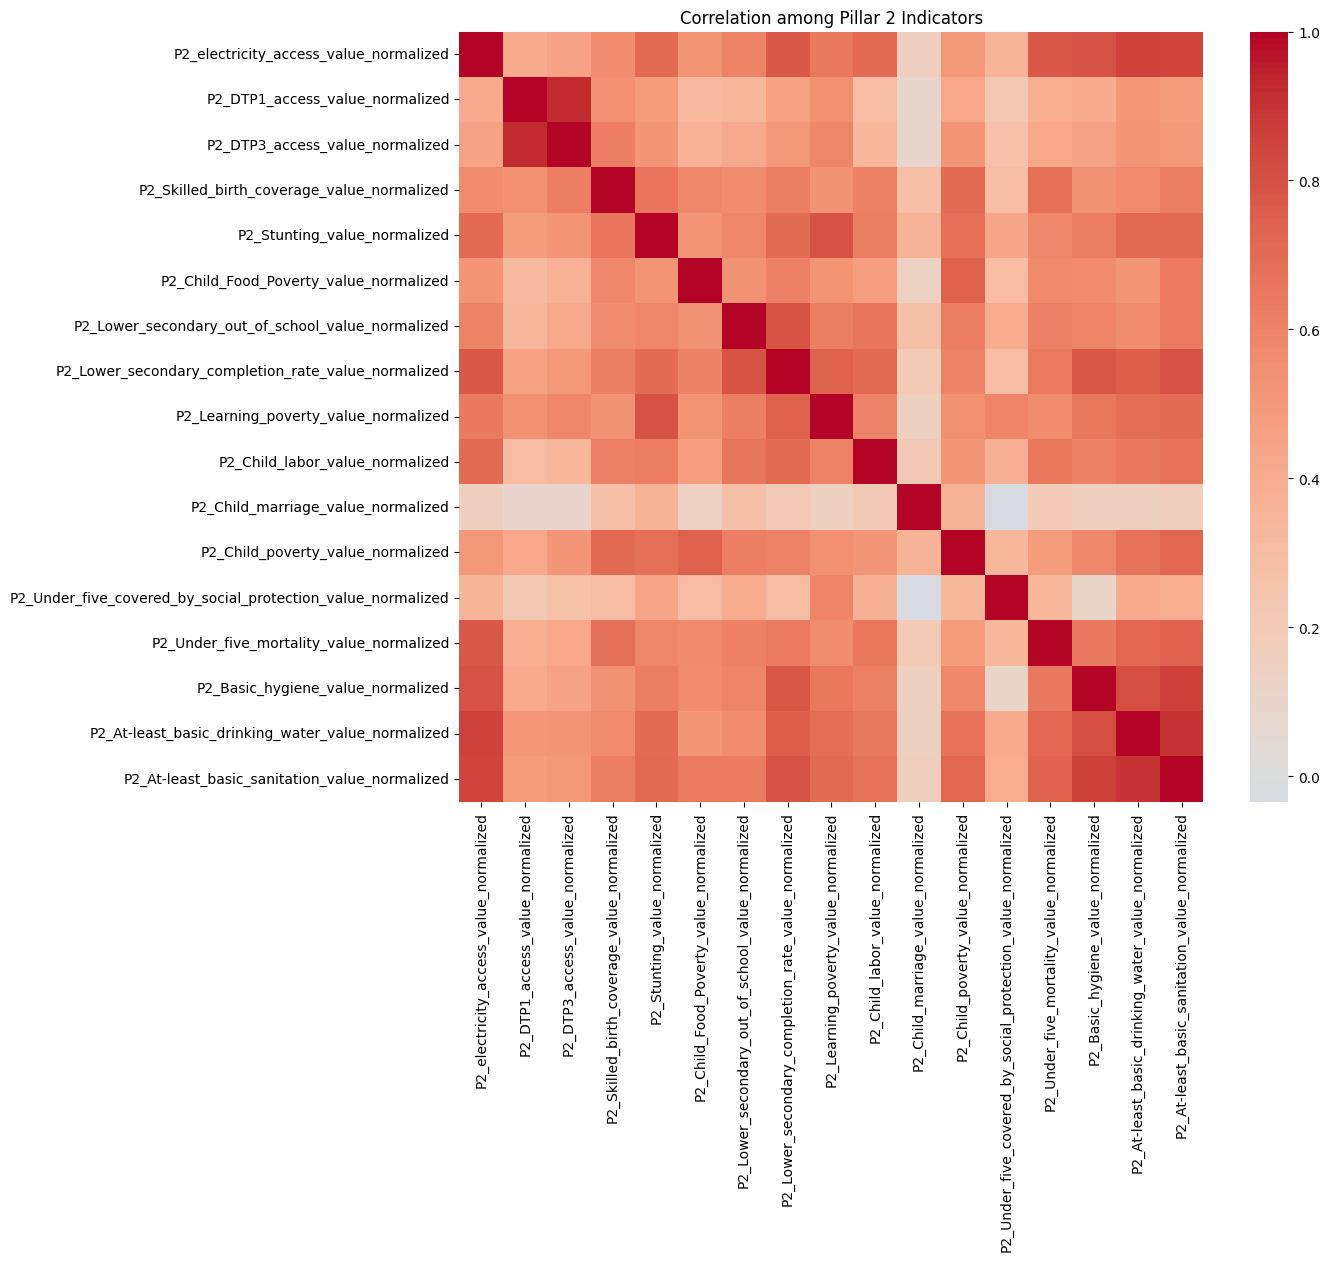

In [226]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the normalized P2 columns
pillar2_columns = [col for col in df_P2_full.columns if col.endswith('_value_normalized')]
df_p2_subset = df_P2_full[pillar2_columns]

# Compute correlation matrix
corr_matrix = df_p2_subset.corr()

# Optional: visualize as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation among Pillar 2 Indicators')
plt.show()
